#1. Library External

In [95]:
!pip install Sastrawi

In [96]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemover, StopWordRemoverFactory, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#2. Cleaning Data

In [97]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/review_gacoan.csv")
df

,nama_tempat,user,review,rating
0,Mie Gacoan Bandung - Buah Batu,Diana,suasananya oke banget!! rame tapi gak sampe me...,5
1,Mie Gacoan Bandung - Buah Batu,Ryon Salim,Memuaskan banget pelayanan nya makanan cepet h...,5
2,Mie Gacoan Bandung - Buah Batu,Sonny Heriawan,"Saudara-saudara sekalian,\nHadirin yang saya h...",5
3,Mie Gacoan Bandung - Buah Batu,Happy Velice,"Tempatnya luas, makanannya kaya agak asam di c...",4
4,Mie Gacoan Bandung - Buah Batu,Novia aprln,"tempatnya nyaman banget, pelayanannya juga pad...",5
...,...,...,...,...
995,Mie Gacoan Bandung - Buah Batu,Ferry Kurniadi,Dh lama mau nyoba tp sllu antri akhirnya gk jd...,3
996,Mie Gacoan Bandung - Buah Batu,Khayla Putri,Makanannya enak,5
997,Mie Gacoan Bandung - Buah Batu,Dhiie,"Makanan ok, layanan ok\ncuma kalo lagi hectic ...",3
998,Mie Gacoan Bandung - Buah Batu,Wanda Melfi,Mantep lah mulai dari pesan nya cepat saji pok...,5


In [98]:
df = df[['review', 'rating']]

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   rating  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [100]:
df['review'] = df['review'].astype(str).str.lower()
df['review'] = df['review'].replace('false', pd.NA)
df = df.dropna(subset=['review'])
df = df[df['review'] != 'false']
df

/tmp/ipython-input-100-176736176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].astype(str).str.lower()
/tmp/ipython-input-100-176736176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].replace('false', pd.NA)


,review,rating
0,suasananya oke banget!! rame tapi gak sampe me...,5
1,memuaskan banget pelayanan nya makanan cepet h...,5
2,"saudara-saudara sekalian,\nhadirin yang saya h...",5
3,"tempatnya luas, makanannya kaya agak asam di c...",4
4,"tempatnya nyaman banget, pelayanannya juga pad...",5
...,...,...
995,dh lama mau nyoba tp sllu antri akhirnya gk jd...,3
996,makanannya enak,5
997,"makanan ok, layanan ok\ncuma kalo lagi hectic ...",3
998,mantep lah mulai dari pesan nya cepat saji pok...,5


In [101]:
df = df.drop_duplicates(subset=['review'])
df

,review,rating
0,suasananya oke banget!! rame tapi gak sampe me...,5
1,memuaskan banget pelayanan nya makanan cepet h...,5
2,"saudara-saudara sekalian,\nhadirin yang saya h...",5
3,"tempatnya luas, makanannya kaya agak asam di c...",4
4,"tempatnya nyaman banget, pelayanannya juga pad...",5
...,...,...
994,mie nya enakk banget rekomen buat dateng kesin...,5
995,dh lama mau nyoba tp sllu antri akhirnya gk jd...,3
997,"makanan ok, layanan ok\ncuma kalo lagi hectic ...",3
998,mantep lah mulai dari pesan nya cepat saji pok...,5


In [102]:
df = df.dropna()

In [103]:
def clean_text(text):
   text = re.sub(r'@[A-Za-z0-9_]+', "", text)  # Mention
   text = re.sub(r'#\w+', "", text)            # Hashtag
   text = re.sub(r'RT[\s]+', "", text)         # Retweet
   text = re.sub(r'https?://\S+', "", text)    # Link

   text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Hapus simbol non-alfanumerik
   text = re.sub(r'\s+', ' ', text)            # Normalisasi spasi jadi satu
   return text.strip()                         # Hapus spasi depan belakang

df['review'] = df['review'].apply(clean_text)
df

,review,rating
0,suasananya oke banget rame tapi gak sampe memb...,5
1,memuaskan banget pelayanan nya makanan cepet h...,5
2,saudarasaudara sekalian hadirin yang saya horm...,5
3,tempatnya luas makanannya kaya agak asam di ca...,4
4,tempatnya nyaman banget pelayanannya juga pada...,5
...,...,...
994,mie nya enakk banget rekomen buat dateng kesin...,5
995,dh lama mau nyoba tp sllu antri akhirnya gk jd...,3
997,makanan ok layanan ok cuma kalo lagi hectic sa...,3
998,mantep lah mulai dari pesan nya cepat saji pok...,5


#3. Preprocessing


##Normalisasi

In [104]:
norm_dict = {' bpk ':' bapak ', ' lg ':' lagi ', 'kyk ':'kayak ',' mkan ':' makan ', ' bljr ':' belajar ',' tak ':' tidak ', ' dpt ':' dapat ', ' gt ':' gitu ', ' rebu ':' ribu ',' skrg ':' sekarang ', ' trs ':' terus ', 'lu ':'kamu ', ' sj ':' saja ', ' jg ':' juga ', ' ga ':' tidak ', ' tsb ':' tersebut ', ' sibangsat ':' bangsat ',' yg ':' yang ', ' udh ':' udah ', 'wkwk ':' ', ' min ':' kak ', ' malem ':' malam', ' malem2 ':' malam ', ' sm ':' sama ', ' dy ':' dia ', ' lg ':' lagi ', ' skrg ':' sekarang ', ' ddpn ':' didepan ', ' makasi ':' makasih ', ' pertamaz ':' pertamax ', ' jg ':' juga ', ' donk ':' dong ', ' ikutann ':' ikutan ', ' banyakk ':' banyak ', ' twt ':' tweet', 'mantaap ':'mantap ', ' juarak':' juara ', 'daridulu ':'dari dulu ', 'siapp ':'siap ', ' gamau ':' tidak mau ', ' sll ':' selalu ', ' qu ':' aku ', ' krn ':' karena ', ' irii':' iri', ' muluu ':' terus ', 'mada ':'masa ', 'jgn ':'jangan ', ' jgn ':' jangan ', ' muluuu ':' terus ', 'ntar ':'nanti ', ' awtnya':' awetnya', 'gg ':'keren ', ' kerennn':' keren ', ' bisaa ':' bisa ', 'gaaa':'tidak ', " yg ": " yang ", ' nyampe':' sampai', ' nyampe ':' sampai ', ' lu ':' kamu ', ' ikhlaaasss ':' ikhlas ', ' gak ':' tidak ', ' klo ':' kalo ', ' amp ': ' sampai ', ' ga ':' tidak ', ' yaaaa':' ya ', 'betolll ':'betul ', ' kaga ':' tidak ', ' idk ':' tidak tahu ', ' jkt ':' jakarta ', ' lo ':' kamu ', ' bjir ':' ', ' kek ':' seperti ', ' yg ':' yang ', ' utk ':' untuk ', 'kismin ':'miskin ', ' kismin ':' miskin ', ' pd ':' pada ', ' dgn ':' dengan ', ' ituu ':' itu ', ' jg ':' juga ', 'yoi':'iya ', ' yoi ':' iya ', 'org2 ':'orang ', ' tak ':' tidak ', ' kyk ':' seperti ', ' sbg ':' sebagai ', ' anjjjj ':' ', ' bgt ':' banget ', 'km ':'kamu ', ' km ':' kamu', ' byk ':' banyak ', ' lg ':' lagi ', ' mrk ':' mereka ', ' blm ':' belum '
,' org ':' orang ', ' one ': ' satu ', ' dg ':' dengan ', ' lali ':' lupa ', ' kyk ':' kayak '}

In [105]:
def normalisasi(text):
  for i in norm_dict:
    text=text.replace(i, norm_dict[i])
  return text


df['review'] = df['review'].apply(lambda x:normalisasi(x))
df

,review,rating
0,suasananya oke banget rame tapi tidak sampe me...,5
1,memuaskan banget pelayanan nya makanan cepet h...,5
2,saudarasaudara sekalian hadirin yang saya horm...,5
3,tempatnya luas makanannya kaya agak asam di ca...,4
4,tempatnya nyaman banget pelayanannya juga pada...,5
...,...,...
994,mie nya enakk banget rekomen buat dateng kesin...,5
995,dh lama mau nyoba tp slkamu antri akhirnya gk ...,3
997,makanan ok layanan ok cuma kalo lagi hectic sa...,3
998,mantep lah mulai dari pesan nya cepat saji pok...,5


## Stopwords

In [106]:
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

new_stop_words = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_stop_words)

def stopword(text):
  text = stop_words_remover_new.remove(text)
  return text

df['review'] = df['review'].apply(lambda x: stopword(x))
df

,review,rating
0,suasananya oke banget rame tidak sampe memblud...,5
1,memuaskan banget pelayanan nya makanan cepet j...,5
2,saudarasaudara sekalian hadirin hormati para p...,5
3,tempatnya luas makanannya kaya asam cabainya s...,4
4,tempatnya nyaman banget pelayanannya pada rama...,5
...,...,...
994,mie nya enakk banget rekomen buat dateng kesin...,5
995,dh lama mau nyoba tp slkamu antri akhirnya gk ...,3
997,makanan layanan cuma kalo hectic samping lampu...,3
998,mantep lah mulai pesan nya cepat saji pokonya ...,5


##Tokenize


In [107]:
tokenized = df['review'].apply(lambda x: x.split())
tokenized

,review
0,"[suasananya, oke, banget, rame, tidak, sampe, ..."
1,"[memuaskan, banget, pelayanan, nya, makanan, c..."
2,"[saudarasaudara, sekalian, hadirin, hormati, p..."
3,"[tempatnya, luas, makanannya, kaya, asam, caba..."
4,"[tempatnya, nyaman, banget, pelayanannya, pada..."
...,...
994,"[mie, nya, enakk, banget, rekomen, buat, daten..."
995,"[dh, lama, mau, nyoba, tp, slkamu, antri, akhi..."
997,"[makanan, layanan, cuma, kalo, hectic, samping..."
998,"[mantep, lah, mulai, pesan, nya, cepat, saji, ..."


##Stemming

In [108]:
def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)
tokenized.to_csv("/content/drive/MyDrive/Dataset/hasil_preprocessing.csv")

suasana oke banget rame tidak sampe membludak berisik gitu cuaca dukung buat stay lama lama nungguin travel berangkat jam kemudian
muas banget layan nya makan cepet jukir resah minta tarif pakir 3k motor bener 2 pungli nya biasa gerai 2k saran manajemen gaco mohon parkir feee saja jangan tukang parkir ganggu terimakasih
saudarasaudara sekali hadirin hormat para cinta kuliner sejati izin saya bicara buah tempat kini jadi bincang hangat kalang
tempat luas makan kaya asam cabai seperti mie gaco biasa layan kurang minta asbak tidak malah kasih plastik sambal jadi terbang duluan pakai
tempat nyaman banget layan pada ramah kaka kaka clear up nya gercep buat resin kotor rasa enak banding gaco belum cobain
sumpah baru kali makan gaco buruk layan nya biasa nya mie di pesan gaco terlakamu pias warna nya pedas nya pas padu terlakamu pedas kayak kurang takar kecap nya
pertama kali kecewa makan bersih mie rambut dalem udang keju rambut pendek mungkin potong rambut laki laki jd gk selera makan huft 

# 4.Labeling

In [109]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/hasil_preprocessing.csv")
df

,Unnamed: 0,review
0,0,suasana oke banget rame tidak sampe membludak ...
1,1,muas banget layan nya makan cepet jukir resah ...
2,2,saudarasaudara sekali hadirin hormat para cint...
3,3,tempat luas makan kaya asam cabai seperti mie ...
4,4,tempat nyaman banget layan pada ramah kaka kak...
...,...,...
988,994,mie nya enakk banget rekomen buat dateng kesin...
989,995,dh lama mau nyoba tp slkamu antri akhir gk jd ...
990,997,makan layan cuma kalo hectic samping lampu mer...
991,998,mantep lah mulai pesan nya cepat saji poko the...


In [110]:
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")

def prediksi_sentimen(teks):
  hasil = classifier(teks)
  return hasil[0]['label']


df['sentiment'] = df['review'].apply(prediksi_sentimen)
df

Device set to use cpu


,Unnamed: 0,review,sentiment
0,0,suasana oke banget rame tidak sampe membludak ...,positive
1,1,muas banget layan nya makan cepet jukir resah ...,negative
2,2,saudarasaudara sekali hadirin hormat para cint...,positive
3,3,tempat luas makan kaya asam cabai seperti mie ...,positive
4,4,tempat nyaman banget layan pada ramah kaka kak...,positive
...,...,...,...
988,994,mie nya enakk banget rekomen buat dateng kesin...,positive
989,995,dh lama mau nyoba tp slkamu antri akhir gk jd ...,negative
990,997,makan layan cuma kalo hectic samping lampu mer...,negative
991,998,mantep lah mulai pesan nya cepat saji poko the...,positive


In [111]:
sentiment_counts = df.sentiment.value_counts()
sentiment_counts

,count
sentiment,
positive,775
negative,201
neutral,17


/tmp/ipython-input-112-910086345.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


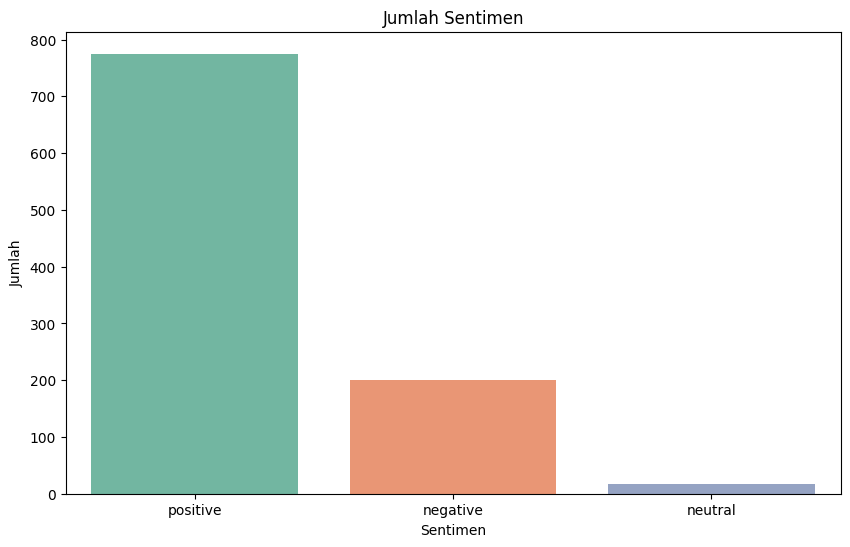

In [112]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Jumlah Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

### **Data Imbalance**

# 5. Train Data (Naive Bayes)

In [113]:
x = df.review
y = df.sentiment

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [114]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()
hvec = HashingVectorizer()

### Penanganan Imbalance

In [115]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter

X = df['review'].values.reshape(-1, 1)
y = df['sentiment']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_resampled = X_resampled.flatten()

print(Counter(y_resampled))

Counter({'positive': 775, 'negative': 775, 'neutral': 775})


In [116]:
clf = MultinomialNB()

In [117]:
model = Pipeline([('vectorizer', tvec), ('classifier', clf)])

In [118]:
model.fit(X_resampled, y_resampled)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [119]:
hasil = model.predict(x_test)

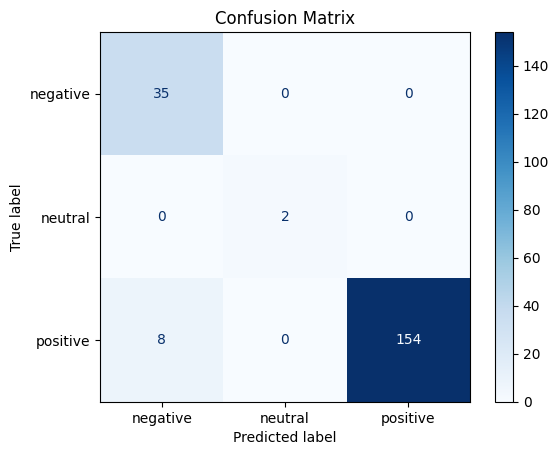

In [120]:
cm = confusion_matrix(y_test, hasil)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [121]:
matrix = classification_report(y_test, hasil, output_dict=True)
matrix = pd.DataFrame(matrix).transpose()
matrix

,precision,recall,f1-score,support
negative,0.813953,1.000000,0.897436,35.000000
neutral,1.000000,1.000000,1.000000,2.000000
positive,1.000000,0.950617,0.974684,162.000000
accuracy,0.959799,0.959799,0.959799,0.959799
macro avg,0.937984,0.983539,0.957373,199.000000
weighted avg,0.967278,0.959799,0.961352,199.000000


#6.Testing

In [122]:
def classify_text(text):
  return model_multinomialNaiveBayes.predict([text])[0]

model_multinomialNaiveBayes = model.fit(X_resampled, y_resampled)

In [124]:
text = input("Masukan teks: ")

result = classify_text(text)
print("Hasil sentiment: ", result)

Masukan teks: hambar
Hasil sentiment:  negative
